In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [82]:
data = pd.read_csv('Pima_Indian_diabetes.csv')

## Data Visualization and Pre-processing

In [83]:
print(data.shape)
data.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.600000,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0.0,26.600000,0.351,31.0,0
2,8.0,183.0,64.0,0.0,0.0,23.300000,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,19.179925,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.100000,2.288,33.0,1


In [84]:
s = 0 
for i in range(768):
    if((data.loc[i].to_numpy() < 0).sum() > 0):
        s+=1
    
print("No.of rows with negative values " + str(s))

No.of rows with negative values 15


Median of Glucose for Diabetic patient is 139.5
Median of Glucose for Non Diabetic patient is 106.0


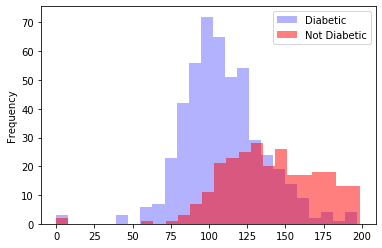

In [85]:
diabetic = data[data['Outcome'] == 1]
diabetic = diabetic[['Glucose', 'Outcome']]
diabetic.dropna(inplace = True)
median_d = np.median(diabetic['Glucose'])

clear = data[data['Outcome'] == 0]
clear = clear[['Glucose', 'Outcome']]
clear.dropna(inplace = True)
median_h = np.median(clear['Glucose'])

clear['Glucose'].plot.hist(alpha=0.3,color='blue',bins=25)
diabetic['Glucose'].plot.hist(alpha=0.5,color='red',bins=25)
plt.legend(['Diabetic','Not Diabetic'])
print("Median of Glucose for Diabetic patient is " + str(median_d))
print("Median of Glucose for Non Diabetic patient is " + str(median_h))

plt.show()

Considering values less than 5th percentile and greater than 98th percentile as outliers

In [86]:
columns = data.columns
j=0
for i in columns:
    q = np.nanquantile(data[i], 0.98)
    mq = np.nanquantile(data[i], 0.05)
    data[i][data[i]<0] = np.nan
    data[i][data[i]<mq] = np.nan
    data[i][data[i]>q] = np.nan
    if(j>0 and j<8):
        data[i][data[i]==0] = np.nan
    j+=1

In [87]:
s = 0 
for i in range(768):
    if(np.isnan(data.loc[i].to_numpy()).sum() > 0):
        s+=1
    
print("No.of rows with nan values " + str(s))

No.of rows with nan values 507


In [88]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,732.000000,699.000000,713.000000,513.000000,378.000000,703.000000,713.000000,736.000000,768.000000
mean,3.797431,121.560856,71.652577,28.169209,138.391534,32.398626,0.462447,33.116769,0.348958
std,3.284213,27.433856,11.022689,9.529269,83.491705,6.022847,0.267097,11.383712,0.476951
min,0.000000,76.000000,40.000000,7.000000,14.000000,21.000000,0.141000,21.000000,0.000000
25%,1.000000,100.000000,64.000000,21.000000,76.000000,27.700000,0.256000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.000000,120.000000,32.400000,0.388000,29.000000,0.000000
75%,6.000000,139.304220,80.000000,35.000000,180.000000,36.450000,0.619000,41.000000,1.000000
max,13.000000,191.000000,98.000000,48.000000,465.000000,46.800000,1.390000,66.000000,1.000000


In [89]:
#new data is data without 'Outcome' 
new_data = data
new_data = data.drop(columns = ["Outcome"])

for i in new_data.columns:
    if(i != 'Insulin' and i != 'SkinThickness' and i!='Glucose'):
        new_data[i].fillna(np.mean(new_data[i]), inplace = True)

Filling Glucose with median grouped by Outcome

In [90]:
new_data.loc[(data['Outcome'] == 0 ) & (data['Glucose'].isnull()), 'Glucose'] = median_h
new_data.loc[(data['Outcome'] == 1 ) & (data['Glucose'].isnull()), 'Glucose'] = median_d

Predicting SkinThickness from BMI:

In [91]:
r = [] #indices without nan values in SkinThickness
nr = [] #indices with nan values in SkinThickness

for i in range(768):
    if(np.isnan(new_data.loc[i,'SkinThickness'])):
        nr.append(i)
    else:
        r.append(i)

# Create dataframe with SkinThickness and BMI without nan values
df_sk = new_data.loc[r,['SkinThickness', 'BMI']]

lir = LinearRegression()
lir.fit(df_sk[['BMI']].values, df_sk['SkinThickness'].values)
p = new_data.loc[nr,['BMI']].to_numpy()

#predictions for nan values in SkinThickness
predictions = lir.predict(p) 

j=0
for i in nr:
    new_data.loc[i,'SkinThickness'] = predictions[j]
    j+=1

In [92]:
print(df_sk.head(3))
df_sk.describe()

   SkinThickness        BMI
0           35.0  33.600000
1           29.0  26.600000
3           23.0  32.398626


,SkinThickness,BMI
count,513.000000,513.000000
mean,28.169209,32.704790
std,9.529269,5.671648
min,7.000000,21.000000
25%,21.000000,28.600000
50%,28.000000,32.398626
75%,35.000000,36.100000
max,48.000000,46.700000


Predicting Insulin from Glucose and BMI:

In [93]:
r = [] #indices without nan values in Insulin
nr = [] #indices with nan values in Insulin

for i in range(768):
    if(np.isnan(new_data.loc[i,'Insulin'])):
        nr.append(i)
    else:
        r.append(i)

# Create dataframe with Insulin, Glucose and BMI without nan values
df_in = new_data.loc[r,['Insulin', 'Glucose', 'BMI']]

lir = LinearRegression()
lir.fit(df_in[['BMI', 'Glucose']].values, df_in['Insulin'].values)
p = new_data.loc[nr,['BMI', "Glucose"]].to_numpy()

predictions = lir.predict(p)#predictions for nan values in Insulin

j=0
for i in nr:
    new_data.loc[i,'Insulin'] = predictions[j]
    j+=1

In [94]:
print(df_in.head(3))
df_in.describe()

   Insulin  Glucose        BMI
3     94.0     89.0  32.398626
4    168.0    137.0  43.100000
6     88.0     78.0  31.000000


,Insulin,Glucose,BMI
count,378.000000,378.000000,378.000000
mean,138.391534,120.288044,32.856790
std,83.491705,26.646089,5.744705
min,14.000000,76.887945,21.100000
25%,76.000000,100.000000,28.700000
50%,120.000000,117.000000,32.450000
75%,180.000000,139.000000,36.475000
max,465.000000,191.000000,46.800000


In [95]:
new_data.to_csv("processed.csv",sep = ",",index = False)
new_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.797431,121.035206,71.652577,27.864083,138.525017,32.398626,0.462447,33.116769
std,3.206213,26.617558,10.620131,8.500884,67.172916,5.761993,0.257342,11.143712
min,0.000000,76.000000,40.000000,7.000000,14.000000,21.000000,0.141000,21.000000
25%,1.000000,102.000000,64.000000,22.000000,92.924083,28.222422,0.259000,24.000000
50%,3.000000,115.000000,71.652577,27.864083,126.418216,32.398626,0.413500,30.000000
75%,6.000000,139.500000,78.000000,33.011954,175.000000,35.825000,0.595500,40.000000
max,13.000000,191.000000,98.000000,48.000000,465.000000,46.800000,1.390000,66.000000


Age vs Outcome Histogram:

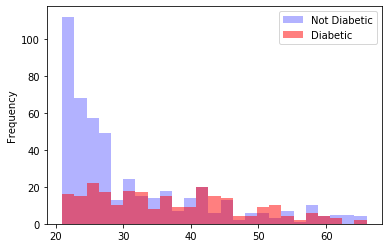

In [96]:
diabetic = data[data['Outcome'] == 1]
clear = data[data['Outcome'] == 0]
clear['Age'].plot.hist(alpha=0.3,color='blue',bins=25)
diabetic['Age'].plot.hist(alpha=0.5,color='red',bins=25)
plt.legend(['Not Diabetic','Diabetic'])
plt.show()

In [97]:
cor = data.corr()
cor.style.background_gradient(cmap='coolwarm')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1,0.0978205,0.20745,0.128529,0.107323,-0.0134364,-0.000969865,0.518913,0.192817
Glucose,0.0978205,1,0.206189,0.198823,0.526833,0.165877,0.0637877,0.2729,0.476782
BloodPressure,0.20745,0.206189,1,0.223472,0.0939482,0.262874,0.0263868,0.311572,0.157885
SkinThickness,0.128529,0.198823,0.223472,1,0.228215,0.620327,0.0507285,0.120309,0.25593
Insulin,0.107323,0.526833,0.0939482,0.228215,1,0.224835,0.108715,0.233123,0.299311
BMI,-0.0134364,0.165877,0.262874,0.620327,0.224835,1,0.137116,0.0457451,0.25673
DiabetesPedigreeFunction,-0.000969865,0.0637877,0.0263868,0.0507285,0.108715,0.137116,1,0.0630516,0.196484
Age,0.518913,0.2729,0.311572,0.120309,0.233123,0.0457451,0.0630516,1,0.244012
Outcome,0.192817,0.476782,0.157885,0.25593,0.299311,0.25673,0.196484,0.244012,1


## Normalisation

Normalising by replacing value by (x-min)/(max-min):

In [98]:
for i in columns[:-1]:
    new_data[i] = (new_data[i]-new_data[i].min())/(new_data[i].max()-new_data[i].min())

In [99]:
print (new_data.head())

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.461538  0.626087       0.551724       0.682927  0.375892  0.488372   
1     0.076923  0.078261       0.448276       0.536585  0.121696  0.217054   
2     0.615385  0.930435       0.413793       0.287715  0.445831  0.089147   
3     0.076923  0.113043       0.448276       0.390244  0.177384  0.441807   
4     0.000000  0.530435       0.000000       0.682927  0.341463  0.856589   

   DiabetesPedigreeFunction       Age  
0                  0.389111  0.644444  
1                  0.168135  0.222222  
2                  0.425140  0.244444  
3                  0.020817  0.000000  
4                  0.257364  0.266667  


## PCA

In [100]:
Covariance = new_data.cov() 
# Eigen decomposition
eigen_vals, eigen_vecs = np.linalg.eig(Covariance)

total = eigen_vals.sum()
print(eigen_vals*100/total) # percentage variance wrt each principal component

[30.58448757 22.03400712 14.24398046 11.30561201  8.34168108  6.85449308
  3.99963562  2.63610305]


In [101]:
# Project X onto PC space
X_pca = np.dot(eigen_vecs, new_data.T)

#datanew is data_frame in which columns are projections of new_data along principal components
datanew = pd.DataFrame(X_pca.T)
datanew.rename(columns={0: "P1", 1: "P2", 2: "P3", 3: "P4", 4: "P5", 5: "P6",6: "P7", 7: "P8"},inplace = True)
datanew.to_csv('EigenProjected.csv',sep=',',index=False)

## Model Fitting and Accuracy

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [103]:
lr = LogisticRegression()
scores = cross_val_score(lr, datanew, data['Outcome'], cv=10)

In [104]:
print("Scores " + str(scores*100))
print("The accuracy of the model is " + str(np.mean(scores)*100) +"%")

Scores [72.72727273 74.02597403 76.62337662 75.32467532 74.02597403 81.81818182
 76.62337662 77.92207792 71.05263158 80.26315789]
The accuracy of the model is 76.04066985645933%
